In [1]:
import os
from os.path import abspath, isfile, basename, join
import cv2

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import concurrent.futures

In [2]:
# Set working directory
os.chdir(os.path.dirname(os.getcwd()))
project_path = os.getcwd()
print(project_path)

/home/ubuntu/master_thesis


In [3]:
# Load local libraries
from src.Fundus import Fundus
from src.get_info_from_name import get_info_from_name
from src.logger import set_logger as sl

In [4]:
# Load file with metadata
ukbb = pd.read_csv("./data/ukbb_metadata.csv")
ukbb.head()

,file,sex,patient_id,eye_side,visit,replica
0,1000180_21015_0_0.png,female,1000180,left,0,0
1,1000180_21016_0_0.png,female,1000180,right,0,0
2,1000303_21015_1_0.png,female,1000303,left,1,0
3,1000303_21016_1_0.png,female,1000303,right,1,0
4,1000390_21015_1_0.png,male,1000390,left,1,0


## Eye side

In [5]:
ukbb.eye_side.value_counts()

right    88156
left     86830
Name: eye_side, dtype: int64

In [6]:
ukbb.eye_side.value_counts()/ukbb.shape[0]

right    0.503789
left     0.496211
Name: eye_side, dtype: float64

## Female/Male distribution

### CFP

In [7]:
ukbb.sex.value_counts()

female    93753
male      81233
Name: sex, dtype: int64

In [8]:
ukbb.sex.value_counts()/ukbb.shape[0]

female    0.535774
male      0.464226
Name: sex, dtype: float64

### Patients

In [9]:
# Number of unique patients
ukbb.patient_id.unique().shape[0]

85623

In [10]:
# Number of patients per sex
for by, df in ukbb.groupby("sex"):
    print(by, df.patient_id.unique().shape[0], df.patient_id.unique().shape[0]/ukbb.patient_id.unique().shape[0], sep="\t")

female	45948	0.5366315125608774
male	39675	0.4633684874391227


## Images

In [11]:
data_path = os.path.abspath(f"/mnt/data/ukbb/")

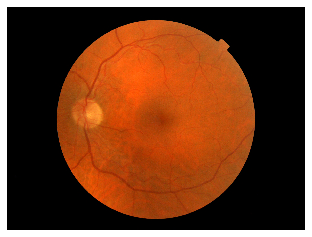

In [12]:
example = os.path.join(data_path, os.listdir(data_path)[2])

# Read image
eye = Fundus(example)

# Show image
eye.show()

In [13]:
# Dimensions 
eye.im.shape

(1536, 2048, 3)

### Get min, max, mean, median and standar deviation for each RGB channel per image

In [14]:
def parallel_stats(f):
    path = join(data_path, f)
    eye = Fundus(path)
    return path, eye.get_rgb_stats()

In [15]:
def parallel_stats_threshold(f):
    path = join(data_path, f)
    eye = Fundus(path)
    mask = eye.get_threshold_mask(mode="sum", threshold=1)
    return path, eye.get_rgb_stats(mask)

In [16]:
colnames = ["file", "min_r", "min_g", "min_b", "max_r", "max_g", "max_b", "med_r", "med_g", "med_b", "mea_r", "mea_g", "mea_b", "std_r", "std_g", "std_b" ]

In [17]:
# Absolute pathways
data_path = abspath("/mnt/data/ukbb/")
labels = abspath("./data/ukbb_metadata.csv")

# Read UKBB labels
ukbb = pd.read_csv(labels)

##### For RAW Images

In [18]:
%%time
# For RAW 
outfile = abspath("./out/ukbb_rgb_stats.csv")

# This will do the normal images
if not isfile(outfile):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = executor.map(parallel_stats, ukbb.file)

    # Get the results
    results = [[basename(p)]+list(s) for p, s in results]

    # Save the results
    ukbb_stats = pd.DataFrame(results, columns=colnames)
    ukbb_stats.to_csv(outfile, index=False)
else:
    ukbb_stats = pd.read_csv(outfile)

CPU times: user 233 ms, sys: 24.2 ms, total: 257 ms
Wall time: 259 ms


In [19]:
# This is to avoid images that area only black pixels
siblack = ukbb_stats[(ukbb_stats.max_r == 0) & (ukbb_stats.max_g == 0) & (ukbb_stats.max_b == 0)]
noblack = ukbb_stats[~((ukbb_stats.max_r == 0) & (ukbb_stats.max_g == 0) & (ukbb_stats.max_b == 0))]
siblack

,file,min_r,min_g,min_b,max_r,max_g,max_b,med_r,med_g,med_b,mea_r,mea_g,mea_b,std_r,std_g,std_b
5947,1169844_21015_1_0.png,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69400,2999106_21015_1_0.png,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70550,3030697_21015_1_0.png,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78253,3247964_21015_1_0.png,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
130993,4759649_21015_1_0.png,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### For masked Images

In [20]:
%%time
# For RAW 
outfile = abspath("./out/ukbb_rgb_stats_masked.csv")

# This will do it for the masked images
if not isfile(abspath(outfile)):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = executor.map(parallel_stats, noblack.file)

    # Get the results
    results = [[basename(p)]+list(s) for p, s in results]

    # Save the results
    ukbb_thr_stats = pd.DataFrame(results, columns=colnames)
    ukbb_thr_stats.to_csv(outfile, index=False)
else:
    ukbb_thr_stats = pd.read_csv(outfile)

CPU times: user 234 ms, sys: 32.4 ms, total: 267 ms
Wall time: 268 ms


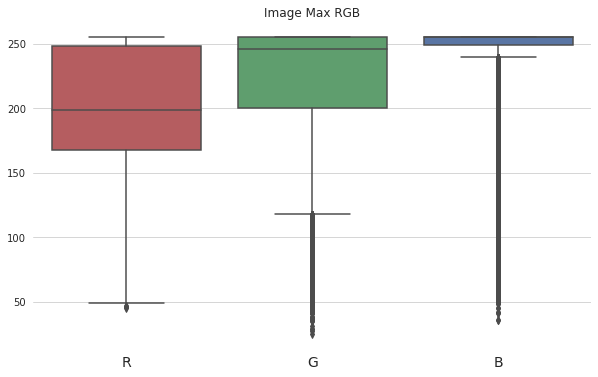

In [21]:
pal = sns.color_palette("deep")
sns.set_palette([pal[3],pal[2],pal[0]])
sns.set_style("whitegrid")

f, ax = plt.subplots(1, 1, figsize=(10,6))
sns.boxplot(data=ukbb_thr_stats[["max_r","max_g","max_b"]], ax=ax)
ax.set_title("Image Max RGB")
ax.set_xticklabels(["R", "G", "B"], size=14)
sns.despine(left=True, bottom=True)
f.savefig(abspath("./out/figures/stats_thr-max.png"))
f.savefig(abspath("./out/figures/stats_thr-max.svg"))

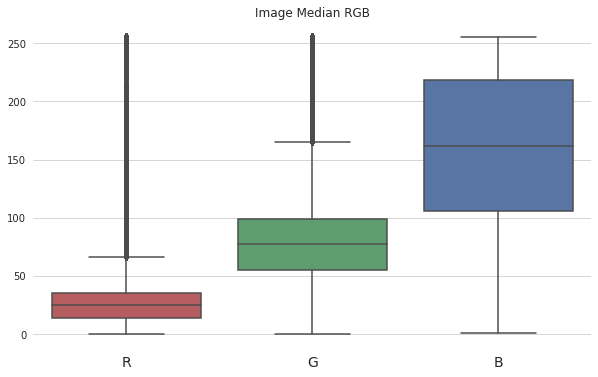

In [22]:
f, ax = plt.subplots(1, 1, figsize=(10,6))
sns.boxplot(data=ukbb_thr_stats[["med_r","med_g","med_b"]])
ax.set_title("Image Median RGB")
ax.set_xticklabels(["R", "G", "B"], size=14)
sns.despine(left=True, bottom=True)
f.savefig(abspath("./out/figures/stats_thr-med.png"))
f.savefig(abspath("./out/figures/stats_thr-med.svg"))

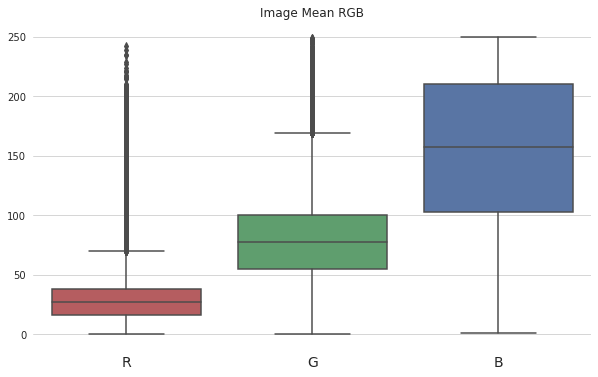

In [23]:
f, ax = plt.subplots(1, 1, figsize=(10,6))
sns.boxplot(data=ukbb_thr_stats[["mea_r","mea_g","mea_b"]])
ax.set_title("Image Mean RGB")
ax.set_xticklabels(["R", "G", "B"], size=14)
sns.despine(left=True, bottom=True)
f.savefig(abspath("./out/figures/stats_thr-mean.png"))
f.savefig(abspath("./out/figures/stats_thr-mean.svg"))

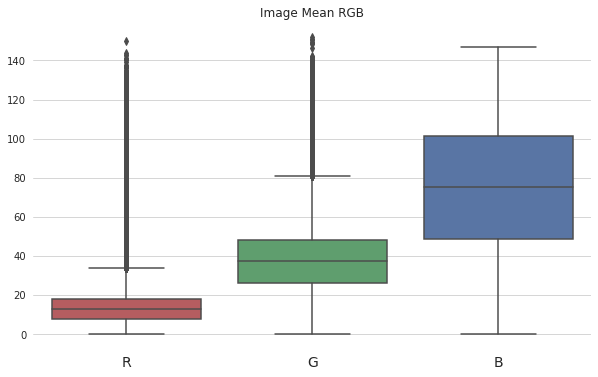

In [24]:
f, ax = plt.subplots(1, 1, figsize=(10,6))
sns.boxplot(data=ukbb_stats[["mea_r","mea_g","mea_b"]])
ax.set_title("Image Mean RGB")
ax.set_xticklabels(["R", "G", "B"], size=14)
sns.despine(left=True, bottom=True)
f.savefig(abspath("./out/figures/stats-mean.png"))
f.savefig(abspath("./out/figures/stats-mean.svg"))

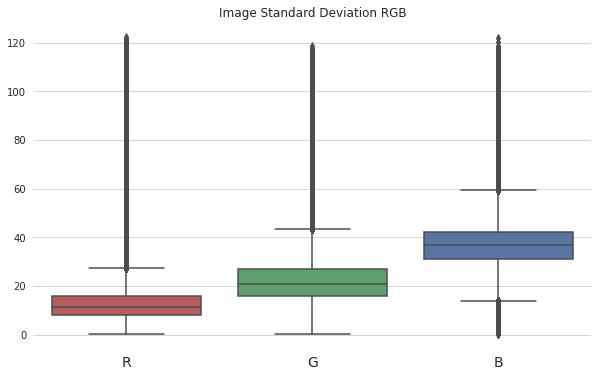

In [25]:
f, ax = plt.subplots(1, 1, figsize=(10,6))
sns.boxplot(data=ukbb_thr_stats[["std_r","std_g","std_b"]])
ax.set_title("Image Standard Deviation RGB")
ax.set_xticklabels(["R", "G", "B"], size=14)
sns.despine(left=True, bottom=True)
f.savefig(abspath("./out/figures/stats_thr-std.png"))
f.savefig(abspath("./out/figures/stats_thr-std.svg"))

In [26]:
ukbb_stats.mean(axis=0)

min_r      0.000000
min_g      0.000000
min_b      0.000000
max_r    197.671111
max_g    223.175671
max_b    242.908176
med_r      0.136714
med_g      0.251066
med_b      0.328075
mea_r     13.987220
mea_g     37.616741
mea_b     73.192362
std_r     17.674694
std_g     42.551816
std_b     81.068393
dtype: float64

In [27]:
ukbb_thr_stats.mean(axis=0)

min_r      0.000000
min_g      0.000000
min_b      0.000000
max_r    197.676759
max_g    223.182048
max_b    242.915116
med_r     26.953981
med_g     78.009427
med_b    158.061635
mea_r     29.005900
mea_g     78.443045
mea_b    152.892694
std_r     13.532497
std_g     22.657549
std_b     36.719169
dtype: float64